In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn


Bad key savefig.frameon in file /Users/yeemayseah/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file /Users/yeemayseah/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file /Users/yeemayseah/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout  # a log filename, sys.stdout or sys.stderr')
You probably 

*Updated 8/18/2021*
### Recall vs applied read depth filter

#### Input

CSV generated by testing pipeline of all true and false calls from all variant callers:
- DeepVariant (latest?)
- DiscoSNP (2.2.10)
- Freebayes (1.3.5)
- GATK (4.0.8.1)
- Lancet (1.1.0)
- VarDict-Java (1.8.2) 
- bcftools (1.13)

Columns from VCF: CHROM, POS, REF, ALT, QUAL, AD (split into AD_REF and AD_ALT), DP, GT (when calls are missed i.e., false negatives, GT value comes from the variants.py mutation list, which is set to 1 by default), RK_DISCOSNP (from INFO/Rk)

Added columns:
- TYPE: from variants.py (options are SNP, INS, DEL only) or from VCF INFO/TYPE if available (options may be different, e.g. SNV)
- INS_TYPE: from variants.py (type of insertion generated)
- BAM_DP: from intersection of two BED files, 1) generated from BAM using `bedtools genomecov -bga` and 2) from variants.py mutation list. If TYPE=DEL, BAM_DP is calculated as average read depths at 5-bp before and after deletion region.
- ZYG: based on GT values ("hom"ozygous or "het"erozygous)
- TOOL and SAMPLE: user input parameter to checker.py
- TRUE_POS, FALSE_POS, FALSE_NEG: checker.py


In [406]:
all_calls = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/output/checked/H37Rv10-3IND1_alltools_normalized_dp0_checked.csv')
#all_calls = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/output/checked/H37Rv10-3IND1_alltools_normalized_dp0_checked_noBAMDPadjustment.csv')

In [407]:
all_calls

,CHROM,POS,REF,ALT,TYPE,INS_TYPE,QUAL,AD_REF,AD_ALT,DP,BAM_DP,GT,ZYG,RK_DISCOSNP,TOOL,SAMPLE,TRUE_POS,FALSE_POS,FALSE_NEG
0,NC_000962.3,1117,GAGGGCGCGCTGATCCGGGTCACCGCGTTCGCCTCATTGAACAAAAC,G,DEL,NaN,1236.97,0.0,28.0,28.0,28,1,hom,NaN,gatk,H37Rv10-3IND1,1,0,0
1,NC_000962.3,1927,TGTTGTTCGA,T,DEL,NaN,1309.97,0.0,30.0,30.0,31,1,hom,NaN,gatk,H37Rv10-3IND1,1,0,0
2,NC_000962.3,2146,ATCTGCCAGCCAGGCCCGCGGTGCCGGTGCTCTCCGGCGTGTTG,A,DEL,NaN,960.97,0.0,22.0,22.0,26,1,hom,NaN,gatk,H37Rv10-3IND1,1,0,0
3,NC_000962.3,3590,GT,G,DEL,NaN,1818.97,0.0,46.0,46.0,47,1,hom,NaN,gatk,H37Rv10-3IND1,1,0,0
4,NC_000962.3,4850,CATGCA,C,DEL,NaN,815.97,0.0,19.0,19.0,23,1,hom,NaN,gatk,H37Rv10-3IND1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40329,NC_000962.3,4404876,T,TAGGTGATCCGAAATGTTCGCTGGATCAAGTGCTGCCAAGTGCTTC...,INS,RDM,209.00,2.0,68.0,70.0,52,1/1,hom,NaN,vardict,H37Rv10-3IND1,1,0,0
40330,NC_000962.3,4406321,G,GCCCATCACGGAAGTGTCCGGGACCGGT,INS,DUP,194.00,27.0,55.0,78.0,59,1/0,het,NaN,vardict,H37Rv10-3IND1,1,0,0
40331,NC_000962.3,4408072,A,AGGC,INS,INV,188.00,4.0,45.0,51.0,49,1/1,hom,NaN,vardict,H37Rv10-3IND1,1,0,0
40332,NC_000962.3,4409601,CCGGG,C,DEL,NaN,188.00,1.0,30.0,31.0,30,1/1,hom,NaN,vardict,H37Rv10-3IND1,1,0,0


In [428]:
all_calls[all_calls['TYPE'] == 'INS'].groupby('TOOL').mean()

,POS,QUAL,AD_REF,AD_ALT,DP,BAM_DP,RK_DISCOSNP,TRUE_POS,FALSE_POS,FALSE_NEG
TOOL,,,,,,,,,,
bcftools,2.146798e+06,202.078416,1.356465,19.160142,20.532028,46.083408,NaN,0.752480,0.007665,0.239856
deepvariant,2.153095e+06,39.918089,0.305361,30.154779,46.024709,45.991877,NaN,0.961191,0.006769,0.032040
discosnp,2.152549e+06,NaN,0.701828,39.779184,40.481013,46.139809,0.966038,0.321834,0.000908,0.677258
freebayes,2.147372e+06,347.433376,1.585624,21.064834,24.858351,46.238915,NaN,0.558330,0.052518,0.389152
gatk,2.151544e+06,1182.094769,0.078096,24.528189,24.618762,46.153358,NaN,0.980490,0.001361,0.018149
lancet,2.165547e+06,75.244506,11.826358,20.984417,32.810775,45.889323,NaN,0.930122,0.044705,0.025174
vardict,2.152959e+06,171.315372,12.722640,36.091896,48.574353,45.815987,NaN,0.818362,0.129007,0.052632


In [424]:
all_calls[all_calls['TYPE'] == 'DEL'].groupby('TOOL').mean()

,POS,QUAL,AD_REF,AD_ALT,DP,BAM_DP,RK_DISCOSNP,TRUE_POS,FALSE_POS,FALSE_NEG
TOOL,,,,,,,,,,
bcftools,2.255032e+06,223.250374,0.392994,23.548464,23.946257,33.627174,NaN,0.974612,0.005172,0.020216
deepvariant,2.251635e+06,34.111454,0.280418,38.623099,39.063688,33.583959,NaN,0.979362,0.007505,0.013133
discosnp,2.254052e+06,NaN,0.663545,37.989967,38.653512,33.710302,0.967473,0.706522,0.000000,0.293478
freebayes,2.252962e+06,392.587055,0.028297,24.289209,24.406715,33.722511,NaN,0.982539,0.001416,0.016045
gatk,2.254010e+06,1411.179547,0.006683,32.479714,32.488305,33.709967,NaN,0.989136,0.000472,0.010392
lancet,2.250626e+06,145.224219,2.060076,28.769158,30.829234,33.721158,NaN,0.975712,0.011677,0.012611
vardict,2.253167e+06,186.618208,0.113918,34.942803,35.193041,33.652072,NaN,0.983992,0.003766,0.012241


In [427]:
all_calls[all_calls['TYPE'] == 'SNP'].groupby('TOOL').mean()

,POS,QUAL,AD_REF,AD_ALT,DP,BAM_DP,RK_DISCOSNP,TRUE_POS,FALSE_POS,FALSE_NEG
TOOL,,,,,,,,,,
bcftools,2.094830e+06,36.240968,0.010753,3.021505,3.043011,10.612903,NaN,0.0,1.0,0.0
deepvariant,2.214496e+06,10.624138,0.034483,40.827586,40.931034,17.965517,NaN,0.0,1.0,0.0
discosnp,7.425995e+05,NaN,31.000000,31.000000,62.000000,29.000000,0.0,0.0,1.0,0.0
freebayes,2.461287e+06,7.594000,23.200000,9.500000,32.900000,34.200000,NaN,0.0,1.0,0.0
lancet,2.203115e+06,3.283792,31.242408,1.041099,32.283507,41.056229,NaN,0.0,1.0,0.0
vardict,1.681323e+06,109.000000,8.800000,10.100000,20.400000,26.300000,NaN,0.0,1.0,0.0


In [421]:
all_calls[all_calls['INS_TYPE'] == 'DUP'].groupby('TOOL').mean()

,POS,QUAL,AD_REF,AD_ALT,DP,BAM_DP,RK_DISCOSNP,TRUE_POS,FALSE_POS,FALSE_NEG
TOOL,,,,,,,,,,
bcftools,2.098530e+06,198.874095,1.787318,18.681638,20.479524,50.036640,NaN,0.676497,0.0,0.323503
deepvariant,2.098530e+06,40.441171,0.274164,30.073420,45.688662,50.036640,NaN,0.961573,0.0,0.038427
discosnp,2.098530e+06,NaN,0.694737,38.171930,38.866667,50.036640,0.963258,0.254692,0.0,0.745308
freebayes,2.098530e+06,390.381418,1.240000,22.292727,26.198182,50.036640,NaN,0.491510,0.0,0.508490
gatk,2.098530e+06,1039.431258,0.103008,21.587056,21.703737,50.036640,NaN,0.980340,0.0,0.019660
lancet,2.098530e+06,58.140676,19.859232,21.962523,41.821755,50.037534,NaN,0.977659,0.0,0.022341
vardict,2.098530e+06,183.921348,10.558989,43.221910,51.960674,50.036640,NaN,0.954424,0.0,0.045576


In [422]:
all_calls[all_calls['INS_TYPE'] == 'INV'].groupby('TOOL').mean()

,POS,QUAL,AD_REF,AD_ALT,DP,BAM_DP,RK_DISCOSNP,TRUE_POS,FALSE_POS,FALSE_NEG
TOOL,,,,,,,,,,
bcftools,2.187506e+06,202.085116,1.080000,20.168421,21.275789,48.012545,NaN,0.851254,0.0,0.148746
deepvariant,2.187506e+06,39.740659,0.364469,30.448718,46.553114,48.012545,NaN,0.978495,0.0,0.021505
discosnp,2.187506e+06,NaN,0.769953,41.535211,42.305164,48.012545,0.968197,0.381720,0.0,0.618280
freebayes,2.187506e+06,387.680794,0.449735,22.410053,24.730159,48.012545,NaN,0.677419,0.0,0.322581
gatk,2.187506e+06,1331.390765,0.074681,27.743169,27.837887,48.012545,NaN,0.983871,0.0,0.016129
lancet,2.187506e+06,76.717753,1.342697,16.649813,17.992509,48.012545,NaN,0.956989,0.0,0.043011
vardict,2.187506e+06,154.647541,12.176230,25.688525,38.985656,48.012545,NaN,0.874552,0.0,0.125448


In [423]:
all_calls[all_calls['INS_TYPE'] == 'RDM'].groupby('TOOL').mean()

,POS,QUAL,AD_REF,AD_ALT,DP,BAM_DP,RK_DISCOSNP,TRUE_POS,FALSE_POS,FALSE_NEG
TOOL,,,,,,,,,,
bcftools,2.225008e+06,213.863066,0.945080,19.524027,20.475973,35.898855,NaN,0.833969,0.0,0.166031
deepvariant,2.225008e+06,39.852559,0.314961,29.750000,46.255906,35.898855,NaN,0.969466,0.0,0.030534
discosnp,2.225008e+06,NaN,0.601896,40.018957,40.620853,35.898855,0.970139,0.402672,0.0,0.597328
freebayes,2.225008e+06,356.937967,0.355014,21.035230,23.168022,35.898855,NaN,0.704198,0.0,0.295802
gatk,2.225008e+06,1325.841845,0.029126,27.421359,27.452427,35.898855,NaN,0.982824,0.0,0.017176
lancet,2.225008e+06,123.389049,4.990291,27.262136,32.252427,35.900763,NaN,0.982824,0.0,0.017176
vardict,2.225008e+06,186.373047,4.242188,43.816406,49.007812,35.898855,NaN,0.977099,0.0,0.022901


## Recall vs. applied BAM_DP filter

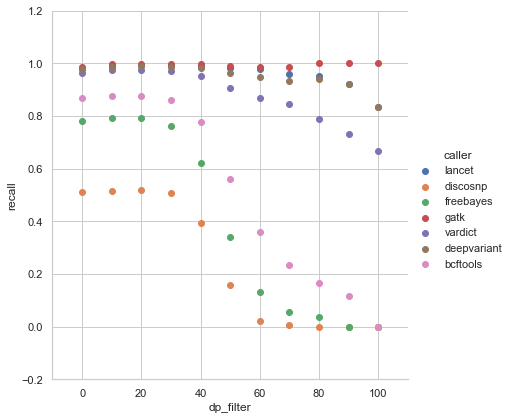

In [429]:
# Filtered on BAM_DP (dataset: H37Rv10-3IND1 has duplications, inversions, and random-sequence insertions)
seaborn.set(style='whitegrid')
fg = seaborn.FacetGrid(data=bamdp_summary_df, hue='caller', height=6, aspect=1, xlim=(-10,110), ylim=(-0.2,1.2))
fg.map(plt.scatter, 'dp_filter', 'recall').add_legend()

## Precision vs. applied BAM_DP filter

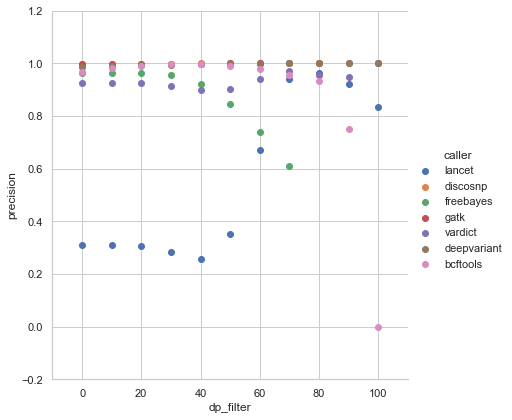

In [430]:
# Filtered on BAM_DP (dataset: H37Rv10-3IND1 has duplications, inversions, and random-sequence insertions)
seaborn.set(style='whitegrid')
fg = seaborn.FacetGrid(data=bamdp_summary_df, hue='caller', height=6, aspect=1, xlim=(-10,110), ylim=(-0.2,1.2))
fg.map(plt.scatter, 'dp_filter', 'precision').add_legend()

## Precision vs. Recall (no filtering by BAM_DP)

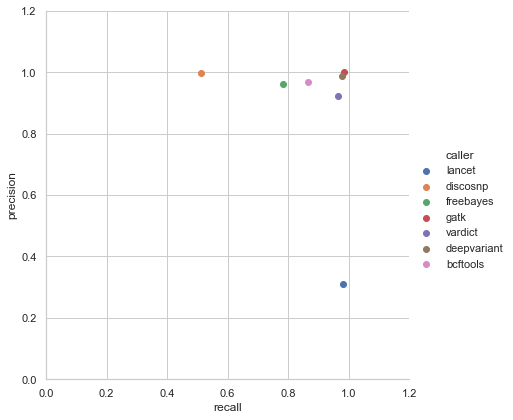

In [446]:
# Filtered on BAM_DP (dataset: H37Rv10-3IND1 has duplications, inversions, and random-sequence insertions)
seaborn.set(style='whitegrid')
fg = seaborn.FacetGrid(data=dp0, hue='caller', height=6, aspect=1, xlim=(0, 1.2), ylim=(0, 1.2))
fg.map(plt.scatter, 'recall', 'precision').add_legend()

## Precision vs. Recall (bcftools)

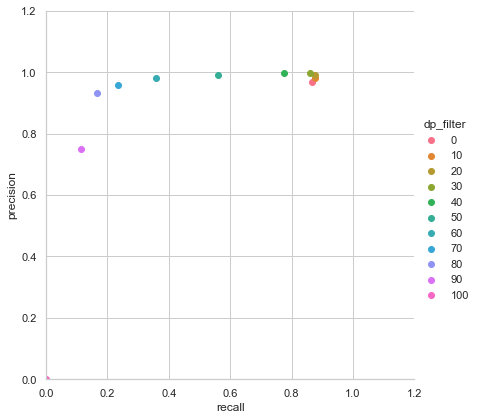

In [444]:
# Filtered on BAM_DP (dataset: H37Rv10-3IND1 has duplications, inversions, and random-sequence insertions)
seaborn.set(style='whitegrid')
fg = seaborn.FacetGrid(data=bamdp_summary_df[bamdp_summary_df.caller == 'bcftools'], hue='dp_filter', height=6, aspect=1, xlim=(0, 1.2), ylim=(0, 1.2))
fg.map(plt.scatter, 'recall', 'precision').add_legend()

## Precision vs. Recall (DeepVariant)

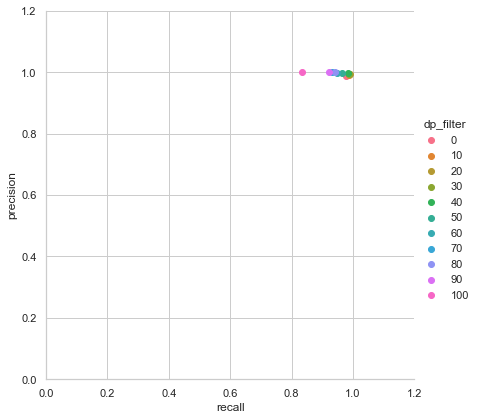

In [445]:
# Filtered on BAM_DP (dataset: H37Rv10-3IND1 has duplications, inversions, and random-sequence insertions)
seaborn.set(style='whitegrid')
fg = seaborn.FacetGrid(data=bamdp_summary_df[bamdp_summary_df.caller == 'deepvariant'], hue='dp_filter', height=6, aspect=1, xlim=(0, 1.2), ylim=(0, 1.2))
fg.map(plt.scatter, 'recall', 'precision').add_legend()

## Precision vs. Recall (DiscoSNP)

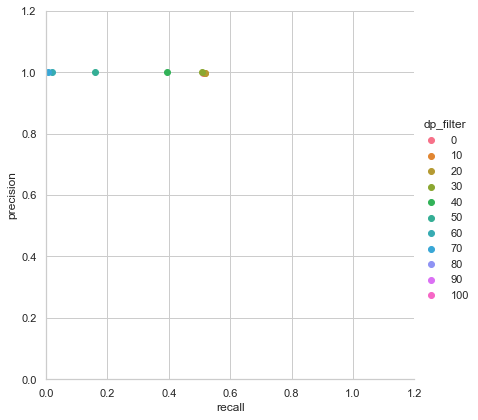

In [447]:
# Filtered on BAM_DP (dataset: H37Rv10-3IND1 has duplications, inversions, and random-sequence insertions)
seaborn.set(style='whitegrid')
fg = seaborn.FacetGrid(data=bamdp_summary_df[bamdp_summary_df.caller == 'discosnp'], hue='dp_filter', height=6, aspect=1, xlim=(0, 1.2), ylim=(0, 1.2))
fg.map(plt.scatter, 'recall', 'precision').add_legend()

## Precision vs. Recall (FreeBayes)

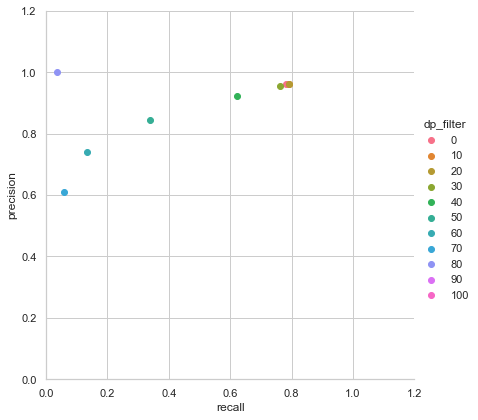

In [448]:
# Filtered on BAM_DP (dataset: H37Rv10-3IND1 has duplications, inversions, and random-sequence insertions)
seaborn.set(style='whitegrid')
fg = seaborn.FacetGrid(data=bamdp_summary_df[bamdp_summary_df.caller == 'freebayes'], hue='dp_filter', height=6, aspect=1, xlim=(0, 1.2), ylim=(0, 1.2))
fg.map(plt.scatter, 'recall', 'precision').add_legend()

## Precision vs. Recall (GATK)

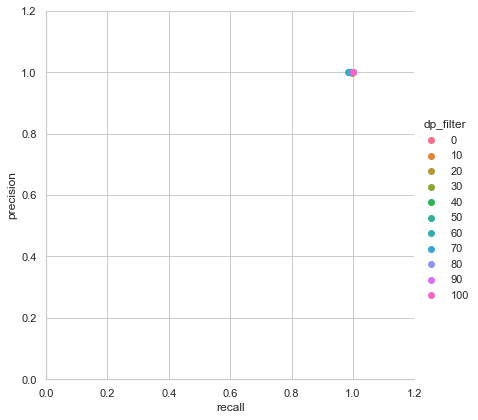

In [443]:
# Filtered on BAM_DP (dataset: H37Rv10-3IND1 has duplications, inversions, and random-sequence insertions)
seaborn.set(style='whitegrid')
fg = seaborn.FacetGrid(data=bamdp_summary_df[bamdp_summary_df.caller == 'gatk'], hue='dp_filter', height=6, aspect=1, xlim=(0, 1.2), ylim=(0, 1.2))
fg.map(plt.scatter, 'recall', 'precision').add_legend()

## Precision vs. Recall (Lancet)

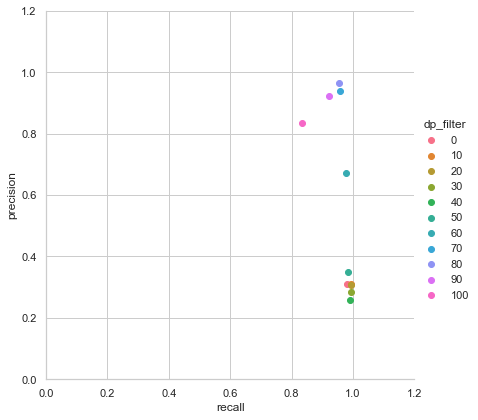

In [449]:
# Filtered on BAM_DP (dataset: H37Rv10-3IND1 has duplications, inversions, and random-sequence insertions)
seaborn.set(style='whitegrid')
fg = seaborn.FacetGrid(data=bamdp_summary_df[bamdp_summary_df.caller == 'lancet'], hue='dp_filter', height=6, aspect=1, xlim=(0, 1.2), ylim=(0, 1.2))
fg.map(plt.scatter, 'recall', 'precision').add_legend()

## Precision vs. Recall (VarDict)

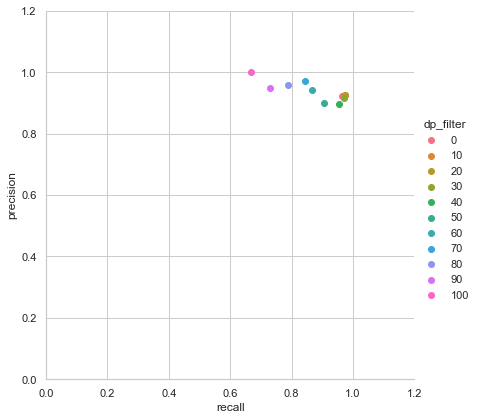

In [450]:
# Filtered on BAM_DP (dataset: H37Rv10-3IND1 has duplications, inversions, and random-sequence insertions)
seaborn.set(style='whitegrid')
fg = seaborn.FacetGrid(data=bamdp_summary_df[bamdp_summary_df.caller == 'vardict'], hue='dp_filter', height=6, aspect=1, xlim=(0, 1.2), ylim=(0, 1.2))
fg.map(plt.scatter, 'recall', 'precision').add_legend()

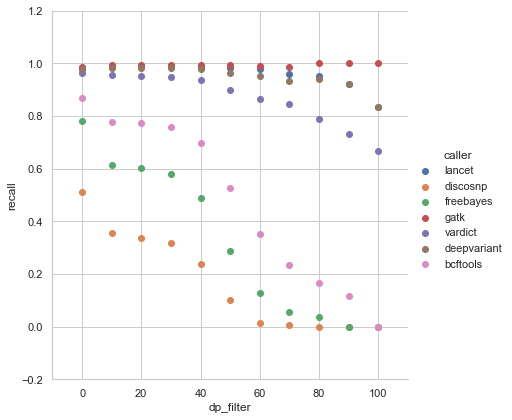

In [405]:
# Filtered on BAM_DP, not adjusted for DEL flanking regions (dataset: H37Rv10-3IND1 has duplications, inversions and random-sequence insertions)
#seaborn.set(style='whitegrid')
#fg = seaborn.FacetGrid(data=bamdp_summary_df, hue='caller', height=6, aspect=1, xlim=(-10,110), ylim=(-0.2,1.2))
#fg.map(plt.scatter, 'dp_filter', 'recall').add_legend()

In [236]:
def sum_filtered(df, filter_column, min_value, variantlog):
    '''
    df: from csv generated by testing pipeline, via checker.py
    filter_column: string of column name to filter by
    min_value: minimum threshold for values to retain when filtering by filter_column
    variantlog: variant settings log generated by testing pipeline, via variants.py
    '''
    sums = {}
    if filter_column == 'DP':
        filtered = df[(df[filter_column] >= min_value) | df[filter_column].isna() & (df['BAM_DP'] >= min_value)]
    else:
        filtered = df[df[filter_column] >= min_value]
    for tool in set(filtered['TOOL']):
        sums[tool] = [sum(filtered.loc[filtered['TOOL'] == tool, 'TRUE_POS']),
                      sum(filtered.loc[filtered['TOOL'] == tool, 'FALSE_POS']),
                      sum(filtered.loc[filtered['TOOL'] == tool, 'FALSE_NEG'])]
    filtered_sums = pd.DataFrame(data=sums).T
    filtered_sums.reset_index(inplace=True)
    filtered_sums.rename(columns={'index': 'caller', 0:'true_pos', 1:'false_pos', 2: 'false_neg'}, inplace=True)
    filtered_sums['dp_filter'] = min_value
    filtered_sums['recall'] = filtered_sums['true_pos'] / (filtered_sums['true_pos'] + filtered_sums['false_neg'])
    filtered_sums['precision'] = filtered_sums['true_pos'] / (filtered_sums['true_pos'] + filtered_sums['false_pos'])
    # Sanity check: When min_value = 0, introduced mutations == postfilter mutations
    with open(variantlog, 'r') as log:
        varsettings = log.readlines()
    filtered_sums['total_mut_intro'] = int(varsettings[2].split(':')[-1].strip())
    filtered_sums['total_mut_postfilter'] = filtered_sums['true_pos'] + filtered_sums['false_neg']
    return filtered_sums

In [415]:
# Filtered on BAM_DP
bamdp_summary_df = pd.concat([dp0, bam_dp10, bam_dp20, bam_dp30, bam_dp40, 
                              bam_dp50, bam_dp60, bam_dp70, bam_dp80, bam_dp90, bam_dp100], ignore_index=True)
bamdp_summary_df

,caller,true_pos,false_pos,false_neg,dp_filter,recall,precision,total_mut_intro,total_mut_postfilter
0,lancet,4232,9447,85,0,0.980310,0.309379,4317,4317
1,discosnp,2204,4,2113,0,0.510540,0.998188,4317,4317
2,freebayes,3379,135,938,0,0.782719,0.961582,4317,4317
3,gatk,4255,4,62,0,0.985638,0.999061,4317,4317
4,vardict,4158,344,159,0,0.963169,0.923590,4317,4317
...,...,...,...,...,...,...,...,...,...
72,freebayes,0,0,6,100,0.000000,NaN,4317,6
73,gatk,6,0,0,100,1.000000,1.000000,4317,6
74,vardict,4,0,2,100,0.666667,1.000000,4317,6
75,deepvariant,5,0,1,100,0.833333,1.000000,4317,6


In [409]:
dp0 = sum_filtered(all_calls, 'BAM_DP', 0, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv10-3IND1.log')
dp0

,caller,true_pos,false_pos,false_neg,dp_filter,recall,precision,total_mut_intro,total_mut_postfilter
0,lancet,4232,9447,85,0,0.980310,0.309379,4317,4317
1,discosnp,2204,4,2113,0,0.510540,0.998188,4317,4317
2,freebayes,3379,135,938,0,0.782719,0.961582,4317,4317
3,gatk,4255,4,62,0,0.985638,0.999061,4317,4317
4,vardict,4158,344,159,0,0.963169,0.923590,4317,4317
5,deepvariant,4218,60,99,0,0.977067,0.985975,4317,4317
6,bcftools,3742,121,575,0,0.866806,0.968677,4317,4317


In [410]:
bam_dp10 = sum_filtered(all_calls, 'BAM_DP', 10, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv10-3IND1.log')
bam_dp10

,caller,true_pos,false_pos,false_neg,dp_filter,recall,precision,total_mut_intro,total_mut_postfilter
0,lancet,4231,9440,34,10,0.992028,0.309487,4317,4265
1,discosnp,2204,4,2061,10,0.516764,0.998188,4317,4265
2,freebayes,3376,134,889,10,0.791559,0.961823,4317,4265
3,gatk,4250,4,15,10,0.996483,0.999060,4317,4265
4,vardict,4155,340,110,10,0.974209,0.924360,4317,4265
5,deepvariant,4213,35,52,10,0.987808,0.991761,4317,4265
6,bcftools,3739,72,526,10,0.876671,0.981107,4317,4265


In [411]:
bam_dp20 = sum_filtered(all_calls, 'BAM_DP', 20, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv10-3IND1.log')
bam_dp20

,caller,true_pos,false_pos,false_neg,dp_filter,recall,precision,total_mut_intro,total_mut_postfilter
0,lancet,4192,9421,26,20,0.993836,0.307941,4317,4218
1,discosnp,2188,3,2030,20,0.518729,0.998631,4317,4218
2,freebayes,3336,130,882,20,0.790896,0.962493,4317,4218
3,gatk,4207,4,11,20,0.997392,0.999050,4317,4218
4,vardict,4111,335,107,20,0.974633,0.924651,4317,4218
5,deepvariant,4170,32,48,20,0.988620,0.992385,4317,4218
6,bcftools,3700,38,518,20,0.877193,0.989834,4317,4218


In [412]:
bam_dp30 = sum_filtered(all_calls, 'BAM_DP', 30, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv10-3IND1.log')
bam_dp30

,caller,true_pos,false_pos,false_neg,dp_filter,recall,precision,total_mut_intro,total_mut_postfilter
0,lancet,3467,8730,22,30,0.993694,0.284250,4317,3489
1,discosnp,1775,2,1715,30,0.508596,0.998875,4317,3490
2,freebayes,2655,123,835,30,0.760745,0.955724,4317,3490
3,gatk,3481,4,9,30,0.997421,0.998852,4317,3490
4,vardict,3387,311,103,30,0.970487,0.915900,4317,3490
5,deepvariant,3448,23,42,30,0.987966,0.993374,4317,3490
6,bcftools,2999,11,491,30,0.859312,0.996346,4317,3490


In [413]:
bam_dp40 = sum_filtered(all_calls, 'BAM_DP', 40, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv10-3IND1.log')
bam_dp40

,caller,true_pos,false_pos,false_neg,dp_filter,recall,precision,total_mut_intro,total_mut_postfilter
0,lancet,1891,5421,17,40,0.991090,0.258616,4317,1908
1,discosnp,754,0,1154,40,0.395178,1.000000,4317,1908
2,freebayes,1188,101,720,40,0.622642,0.921645,4317,1908
3,gatk,1901,2,7,40,0.996331,0.998949,4317,1908
4,vardict,1820,208,88,40,0.953878,0.897436,4317,1908
5,deepvariant,1877,5,31,40,0.983753,0.997343,4317,1908
6,bcftools,1482,5,426,40,0.776730,0.996638,4317,1908


In [414]:
bam_dp50 = sum_filtered(all_calls, 'BAM_DP', 50, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv10-3IND1.log')
bam_dp60 = sum_filtered(all_calls, 'BAM_DP', 60, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv10-3IND1.log')
bam_dp70 = sum_filtered(all_calls, 'BAM_DP', 70, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv10-3IND1.log')
bam_dp80 = sum_filtered(all_calls, 'BAM_DP', 80, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv10-3IND1.log')
bam_dp90 = sum_filtered(all_calls, 'BAM_DP', 90, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv10-3IND1.log')
bam_dp100 = sum_filtered(all_calls, 'BAM_DP', 100, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv10-3IND1.log')

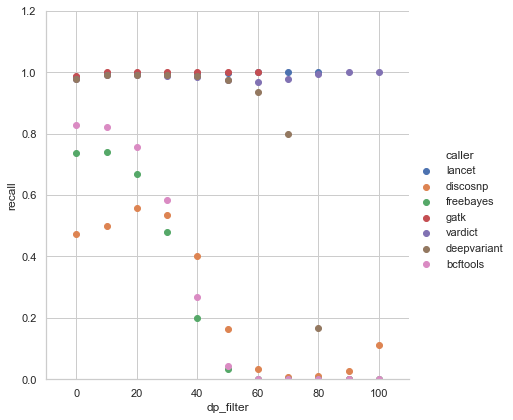

In [395]:
# Filtered on DP
seaborn.set(style='whitegrid')
fg = seaborn.FacetGrid(data=dp_summary_df, hue='caller', height=6, aspect=1, xlim=(-10,110), ylim=(0,1.2))
fg.map(plt.scatter, 'dp_filter', 'recall').add_legend()

In [133]:
# Filtered on DP
dp_summary_df = pd.concat([dp0, dp10, dp20, dp30, dp40,
                           dp50, dp60, dp70, dp80, dp90, dp100], ignore_index=True)
dp_summary_df

,caller,true_pos,false_pos,false_neg,dp_filter,recall,precision,total_mut_intro,total_mut_postfilter
0,lancet,4284,9470,72,0,0.983471,0.311473,4356,4356
1,discosnp,2066,2,2290,0,0.474288,0.999033,4356,4356
2,freebayes,3210,156,1146,0,0.736915,0.953654,4356,4356
3,gatk,4301,0,55,0,0.987374,1.000000,4356,4356
4,vardict,4263,604,93,0,0.978650,0.875899,4356,4356
...,...,...,...,...,...,...,...,...,...
65,vardict,52,5,0,90,1.000000,0.912281,4356,52
66,discosnp,1,0,8,100,0.111111,1.000000,4356,9
67,freebayes,0,0,8,100,0.000000,NaN,4356,8
68,vardict,11,0,0,100,1.000000,1.000000,4356,11


In [387]:
dp10 = sum_filtered(all_calls, 'DP', 10, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv10-3IND1.log')
dp20 = sum_filtered(all_calls, 'DP', 20, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv10-3IND1.log')
dp30 = sum_filtered(all_calls, 'DP', 30, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv10-3IND1.log')
dp40 = sum_filtered(all_calls, 'DP', 40, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv10-3IND1.log')
dp50 = sum_filtered(all_calls, 'DP', 50, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv10-3IND1.log')
dp60 = sum_filtered(all_calls, 'DP', 60, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv10-3IND1.log')
dp70 = sum_filtered(all_calls, 'DP', 70, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv10-3IND1.log')
dp80 = sum_filtered(all_calls, 'DP', 80, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv10-3IND1.log')
dp90 = sum_filtered(all_calls, 'DP', 90, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv10-3IND1.log')
dp100 = sum_filtered(all_calls, 'DP', 100, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv10-3IND1.log')

*8/18/21*
#### Troubleshooting for missing mutation in Lancet postfiltering at BAM_DP >= 30

Additional read depth values were used in calculating BAM_DP for Lancet because the left-flanking position for DEL at POS 1047765 was also called as another DEL by Lancet. This edge case has not yet been addressed in the code.

In [381]:
all_calls[all_calls['POS'] == 1047765]

,CHROM,POS,REF,ALT,TYPE,INS_TYPE,QUAL,AD_REF,AD_ALT,DP,BAM_DP,GT,ZYG,RK_DISCOSNP,TOOL,SAMPLE,TRUE_POS,FALSE_POS,FALSE_NEG
1044,NC_000962.3,1047765,CAGATGCAGAATCGGGGCCGCG,C,DEL,NaN,1476.97,0.0,34.0,34.0,35,1,hom,NaN,gatk,H37Rv10-3IND1,1,0,0
5399,NC_000962.3,1047765,CAGATGCAGAATCGGGGCCGCG,C,DEL,NaN,228.35,1.0,26.0,27.0,35,1,hom,NaN,bcftools,H37Rv10-3IND1,1,0,0
9834,NC_000962.3,1047765,CAGATGCAGAATCGGGGCCGCG,C,DEL,NaN,325.88,0.0,26.0,26.0,35,1,hom,NaN,freebayes,H37Rv10-3IND1,1,0,0
14269,NC_000962.3,1047765,CAGATGCAGAATCGGGGCCGCG,C,DEL,NaN,41.50,0.0,40.0,40.0,35,1/1,hom,NaN,deepvariant,H37Rv10-3IND1,1,0,0
18634,NC_000962.3,1047765,CAGATGCAGAATCGGGGCCGCG,C,DEL,NaN,NaN,3.0,40.0,43.0,35,1/1,hom,0.94124,discosnp,H37Rv10-3IND1,1,0,0
25179,NC_000962.3,1047765,CAGATGCAGAATCGGGGCCGCG,C,DEL,NaN,168.45,3.0,28.0,31.0,26,0/1,het,NaN,lancet,H37Rv10-3IND1,1,0,0
36791,NC_000962.3,1047765,CAGATGCAGAATCGGGGCCGCG,C,DEL,NaN,194.00,0.0,39.0,40.0,35,1/1,hom,NaN,vardict,H37Rv10-3IND1,1,0,0


In [382]:
all_calls[all_calls['POS'] == 1047760]

,CHROM,POS,REF,ALT,TYPE,INS_TYPE,QUAL,AD_REF,AD_ALT,DP,BAM_DP,GT,ZYG,RK_DISCOSNP,TOOL,SAMPLE,TRUE_POS,FALSE_POS,FALSE_NEG
25178,NC_000962.3,1047760,TCAGCCAGATGCAGAATCGGGG,T,DEL,NaN,13.71,1.0,1.0,2.0,18,0/1,het,NaN,lancet,H37Rv10-3IND1,0,1,0


*8/3/2021*
#### Why do discoSNP, FreeBayes, and bcftools recall values trend downwards when read depth filters are applied?

##### *Data*
- Introduced mutations: 4356 total (2196 INS + 2160 DEL)
- All FN calls: 2292 total (1628 INS + 664 DEL)
- 1 FN unique to DeepVariant; called by all other callers.
- 2291 of FN can be found in discoSNP, FreeBayes, or bcftools. 


#### Did filtering by BAM_DP matter?

Not for bcftools, DiscoSNP and FreeBayes, where 59-89% of FNs have BAM_DP >= 40. In comparison, the other callers only have 0-42% FNs with BAM_DP >= 40

**bcftools:** 667/744 (90%) FN have BAM_DP >= 40


**DiscoSNP:** 1340/2290 (59%) FN have BAM_DP >= 40


**FreeBayes:** 1003/1146 (88%) FN have BAM_DP >= 40


**GATK:** 0/55 FN have BAM_DP >= 40


**DeepVariant:** 30/92 FN (33%) have BAM_DP >= 40


**VarDict:** 39/93 FN (42%) have BAM_DP >= 40


**Lancet:** 2/72 FN (0.03%) have BAM_DP >= 40


In [207]:
all_calls[all_calls['FALSE_NEG'] == 1].sort_values('POS')

,CHROM,POS,REF,ALT,TYPE,QUAL,AD_REF,AD_ALT,DP,BAM_DP,GT,ZYG,RK_DISCOSNP,TOOL,SAMPLE,TRUE_POS,FALSE_POS,FALSE_NEG,INDEL_LEN
8843,NC_000962.3,957,A,AACCCGCTTTGAGTGGGGGCTGATCACTGACGTACAACC,INS,NaN,NaN,NaN,NaN,76,1,hom,NaN,freebayes,TEST-H37Rv10-3IND,0,0,1,38
17713,NC_000962.3,957,A,AACCCGCTTTGAGTGGGGGCTGATCACTGACGTACAACC,INS,NaN,NaN,NaN,NaN,76,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0,0,1,38
4357,NC_000962.3,1963,C,CACGCGTCATGGGCATTCGTCGTTGGCAGTCCCCACGCTAGCGGGG...,INS,NaN,NaN,NaN,NaN,75,1,hom,NaN,bcftools,TEST-H37Rv10-3IND,0,0,1,50
17714,NC_000962.3,1963,C,CACGCGTCATGGGCATTCGTCGTTGGCAGTCCCCACGCTAGCGGGG...,INS,NaN,NaN,NaN,NaN,75,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0,0,1,50
8844,NC_000962.3,1963,C,CACGCGTCATGGGCATTCGTCGTTGGCAGTCCCCACGCTAGCGGGG...,INS,NaN,NaN,NaN,NaN,75,1,hom,NaN,freebayes,TEST-H37Rv10-3IND,0,0,1,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13349,NC_000962.3,4405732,T,TCTCCTCGGTGGCTCGCACCGACAGGCCCTCCGCGA,INS,NaN,NaN,NaN,NaN,52,1,hom,NaN,freebayes,TEST-H37Rv10-3IND,0,0,1,35
22067,NC_000962.3,4407714,T,TTTGATGGCGAGCATTCGCCC,INS,NaN,NaN,NaN,NaN,44,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0,0,1,20
22068,NC_000962.3,4408757,G,GTCGCCTGCAATCTCGCCCTCGGCGACCAAT,INS,NaN,NaN,NaN,NaN,56,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0,0,1,30
22069,NC_000962.3,4409770,C,CTCGCGTTGCAGCTT,INS,NaN,NaN,NaN,NaN,35,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0,0,1,14


In [187]:
all_calls[(all_calls['FALSE_NEG'] == 1) & (all_calls['BAM_DP'] >= 40) & (all_calls['TOOL'] == 'bcftools')].shape

(667, 19)

In [188]:
667/744

0.896505376344086

#### What are the mean and median differences between INS lengths of the FN and TP calls?

In [153]:
all_calls['INDEL_LEN'] = abs(all_calls['ALT'].str.len() - all_calls['REF'].str.len())

In [181]:
# FN INS median
all_calls[(all_calls['FALSE_NEG'] == 1) & (all_calls['TYPE'] == 'INS')].groupby('TOOL')['INDEL_LEN'].median()

TOOL
bcftools       42.0
deepvariant    39.0
discosnp       32.0
freebayes      38.0
gatk           35.5
lancet         35.0
vardict        37.0
Name: INDEL_LEN, dtype: float64

In [166]:
# TP INS median
all_calls[(all_calls['TRUE_POS'] == 1) & (all_calls['TYPE'] == 'INS')].groupby('TOOL')['INDEL_LEN'].median()

TOOL
bcftools       17
deepvariant    25
discosnp        8
freebayes      13
gatk           25
lancet         25
vardict        25
Name: INDEL_LEN, dtype: int64

In [180]:
# FN INS mean
all_calls[(all_calls['FALSE_NEG'] == 1) & (all_calls['TYPE'] == 'INS')].groupby('TOOL')['INDEL_LEN'].mean()

TOOL
bcftools       41.643646
deepvariant    36.291667
discosnp       31.889435
freebayes      37.219251
gatk           30.611111
lancet         30.069767
vardict        34.864865
Name: INDEL_LEN, dtype: float64

In [165]:
# TP INS mean
all_calls[(all_calls['TRUE_POS'] == 1) & (all_calls['TYPE'] == 'INS')].groupby('TOOL')['INDEL_LEN'].mean()

TOOL
bcftools       17.643342
deepvariant    25.192090
discosnp        7.403169
freebayes      13.371508
gatk           25.471759
lancet         25.465862
vardict        25.231385
Name: INDEL_LEN, dtype: float64

#### What are the mean and median differences between DEL lengths of the FN and TP calls?

In [173]:
# FN DEL median
all_calls[(all_calls['FALSE_NEG'] == 1) & (all_calls['TYPE'] == 'DEL')].groupby('TOOL')['INDEL_LEN'].median()

TOOL
bcftools       18.5
deepvariant    18.5
discosnp       37.0
freebayes      19.5
gatk           13.0
lancet         19.0
vardict        18.0
Name: INDEL_LEN, dtype: float64

In [175]:
# TP DEL median
all_calls[(all_calls['TRUE_POS'] == 1) & (all_calls['TYPE'] == 'DEL')].groupby('TOOL')['INDEL_LEN'].median()

TOOL
bcftools       26.0
deepvariant    26.0
discosnp       19.0
freebayes      25.5
gatk           26.0
lancet         26.0
vardict        26.0
Name: INDEL_LEN, dtype: float64

In [172]:
# FN DEL mean
all_calls[(all_calls['FALSE_NEG'] == 1) & (all_calls['TYPE'] == 'DEL')].groupby('TOOL')['INDEL_LEN'].mean()

TOOL
bcftools       21.350000
deepvariant    20.250000
discosnp       35.469789
freebayes      23.916667
gatk           18.210526
lancet         20.586207
vardict        20.263158
Name: INDEL_LEN, dtype: float64

In [174]:
# TP DEL mean
all_calls[(all_calls['TRUE_POS'] == 1) & (all_calls['TYPE'] == 'DEL')].groupby('TOOL')['INDEL_LEN'].mean()

TOOL
bcftools       25.566822
deepvariant    25.577103
discosnp       21.134179
freebayes      25.545880
gatk           25.592714
lancet         25.595026
vardict        25.574498
Name: INDEL_LEN, dtype: float64

In [36]:
def count_mutations(df, caller):
    ins = 0
    dele = 0
    snp = 0
    for mut in df[df['TOOL'] == caller]['TYPE']:
        if mut == 'INS':
            ins += 1
        elif mut == 'DEL':
            dele += 1
        elif mut == 'SNP':
            snp += 1
    print('INS:', str(ins))
    print('DEL:', str(dele))
    print('SNP:', str(snp)) 
    print('TOTAL:', str(ins+dele+snp))

#### Introduced mutations

In [37]:
count_mutations(all_calls[(all_calls['TRUE_POS'] == 1) | (all_calls['FALSE_NEG'] == 1)], 'freebayes') # same numbers for any of the tools

INS: 2196
DEL: 2160
SNP: 0
TOTAL: 4356


#### FN: All callers
FN calls total: 2292 = 1628 INS + 664 DEL.

In [38]:
len(set(all_calls[all_calls['FALSE_NEG'] == 1]['POS']))

2292

In [197]:
all_calls[(all_calls['FALSE_NEG'] == 1) & (all_calls['TYPE'] == 'INS')].groupby('POS').count()

,CHROM,REF,ALT,TYPE,QUAL,AD_REF,AD_ALT,DP,BAM_DP,GT,ZYG,RK_DISCOSNP,TOOL,SAMPLE,TRUE_POS,FALSE_POS,FALSE_NEG,INDEL_LEN
POS,,,,,,,,,,,,,,,,,,
957,2,2,2,2,0,0,0,0,2,2,2,0,2,2,2,2,2,2
1963,3,3,3,3,0,0,0,0,3,3,3,0,3,3,3,3,3,3
2966,2,2,2,2,0,0,0,0,2,2,2,0,2,2,2,2,2,2
4951,1,1,1,1,0,0,0,0,1,1,1,0,1,1,1,1,1,1
9982,2,2,2,2,0,0,0,0,2,2,2,0,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405732,3,3,3,3,0,0,0,0,3,3,3,0,3,3,3,3,3,3
4407714,1,1,1,1,0,0,0,0,1,1,1,0,1,1,1,1,1,1
4408757,1,1,1,1,0,0,0,0,1,1,1,0,1,1,1,1,1,1


In [206]:
all_calls[all_calls['POS'] == 9982]

,CHROM,POS,REF,ALT,TYPE,QUAL,AD_REF,AD_ALT,DP,BAM_DP,GT,ZYG,RK_DISCOSNP,TOOL,SAMPLE,TRUE_POS,FALSE_POS,FALSE_NEG,INDEL_LEN
9,NC_000962.3,9982,C,CCGTGGGGGCGCACATCGGGCAG,INS,1393.97,0.0,31.0,31.0,52,1,hom,NaN,gatk,TEST-H37Rv10-3IND,1,0,0,22
4365,NC_000962.3,9982,C,CCGTGGGGGCGCACATCGGGCAG,INS,228.42,1.0,13.0,15.0,52,1,hom,NaN,bcftools,TEST-H37Rv10-3IND,1,0,0,22
8852,NC_000962.3,9982,C,CCGTGGGGGCGCACATCGGGCAG,INS,0.00,14.0,13.0,32.0,52,0,hom,NaN,freebayes,TEST-H37Rv10-3IND,0,1,0,22
8853,NC_000962.3,9982,C,CCGTGGGGGCGCACATCGGGCAG,INS,NaN,NaN,NaN,NaN,52,1,hom,NaN,freebayes,TEST-H37Rv10-3IND,0,0,1,22
13364,NC_000962.3,9982,C,CCGTGGGGGCGCACATCGGGCAG,INS,40.60,0.0,38.0,55.0,52,1/1,hom,NaN,deepvariant,TEST-H37Rv10-3IND,1,0,0,22
17722,NC_000962.3,9982,C,CCGTGGGGGCGCACATCGGGCAG,INS,NaN,NaN,NaN,NaN,52,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0,0,1,22
22096,NC_000962.3,9982,C,CCGTGGGGGCGCACATCGGGCAG,INS,54.95,29.0,27.0,56.0,52,0/1,het,NaN,lancet,TEST-H37Rv10-3IND,1,0,0,22
35906,NC_000962.3,9982,C,CCGTGGGGGCGCACATCGGGCAG,INS,193.00,11.0,47.0,55.0,52,1/1,hom,NaN,vardict,TEST-H37Rv10-3IND,1,0,0,22


#### FN: By caller

In [40]:
count_mutations(all_calls[all_calls['FALSE_NEG'] == 1], 'bcftools')

INS: 724
DEL: 20
SNP: 0
TOTAL: 744


In [41]:
count_mutations(all_calls[all_calls['FALSE_NEG'] == 1], 'discosnp')

INS: 1628
DEL: 662
SNP: 0
TOTAL: 2290


In [42]:
count_mutations(all_calls[all_calls['FALSE_NEG'] == 1], 'freebayes')

INS: 1122
DEL: 24
SNP: 0
TOTAL: 1146


In [43]:
count_mutations(all_calls[all_calls['FALSE_NEG'] == 1], 'gatk')

INS: 36
DEL: 19
SNP: 0
TOTAL: 55


In [44]:
count_mutations(all_calls[all_calls['FALSE_NEG'] == 1], 'deepvariant')

INS: 72
DEL: 20
SNP: 0
TOTAL: 92


In [45]:
count_mutations(all_calls[all_calls['FALSE_NEG'] == 1], 'lancet')

INS: 43
DEL: 29
SNP: 0
TOTAL: 72


In [46]:
count_mutations(all_calls[all_calls['FALSE_NEG'] == 1], 'vardict')

INS: 74
DEL: 19
SNP: 0
TOTAL: 93


#### bcftools and FreeBayes

- 744 FN shared
- 0 FN bcftools only
- 402 FN FreeBayes only

In [79]:
# bcftools and FreeBayes
bcffreebayes_union = pd.merge(all_calls[(all_calls['FALSE_NEG'] == 1) & (all_calls['TOOL'] == 'bcftools')], 
         all_calls[(all_calls['FALSE_NEG'] == 1) & (all_calls['TOOL'] == 'freebayes')], 
         how='inner', on='POS')
bcffreebayes_union

,CHROM_x,POS,REF_x,ALT_x,TYPE_x,QUAL_x,AD_REF_x,AD_ALT_x,DP_x,BAM_DP_x,...,DP_y,BAM_DP_y,GT_y,ZYG_y,RK_DISCOSNP_y,TOOL_y,SAMPLE_y,TRUE_POS_y,FALSE_POS_y,FALSE_NEG_y
0,NC_000962.3,1963,C,CACGCGTCATGGGCATTCGTCGTTGGCAGTCCCCACGCTAGCGGGG...,INS,NaN,NaN,NaN,NaN,75,...,NaN,75,1,hom,NaN,freebayes,TEST-H37Rv10-3IND,0,0,1
1,NC_000962.3,19080,G,GTATCCGACGGTGGTTGAGATATTGGCTAGGTCCGGTCCCTTGAGGC,INS,NaN,NaN,NaN,NaN,66,...,NaN,66,1,hom,NaN,freebayes,TEST-H37Rv10-3IND,0,0,1
2,NC_000962.3,28979,C,CCAGGCGGGTGTTCACCTGGATCGCACCACCTATCAACAGATCAACGA,INS,NaN,NaN,NaN,NaN,87,...,NaN,87,1,hom,NaN,freebayes,TEST-H37Rv10-3IND,0,0,1
3,NC_000962.3,30011,C,CCGCGCAGCTCGATCTGCAGGTCGTCTCGGCAATTCTGAA,INS,NaN,NaN,NaN,NaN,53,...,NaN,53,1,hom,NaN,freebayes,TEST-H37Rv10-3IND,0,0,1
4,NC_000962.3,36042,C,CCCATGCGCTGGGCGTGCTCGGCCCCGACGGGCGAGGAGCTTCG,INS,NaN,NaN,NaN,NaN,76,...,NaN,76,1,hom,NaN,freebayes,TEST-H37Rv10-3IND,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,NC_000962.3,4389541,T,TCGCGGTGATCACCGCCTCGGCGTGCGACACCACCGC,INS,NaN,NaN,NaN,NaN,47,...,NaN,47,1,hom,NaN,freebayes,TEST-H37Rv10-3IND,0,0,1
740,NC_000962.3,4392532,C,CGCAACGGATCGTCGCCAAAGGACCCCGACGGCGCCGCCGGGGTG,INS,NaN,NaN,NaN,NaN,83,...,NaN,83,1,hom,NaN,freebayes,TEST-H37Rv10-3IND,0,0,1
741,NC_000962.3,4395680,C,CCCCGTACCCAAATCCTGGTGCCGCCGGCGTCGTGGAGCCTGGCCAG,INS,NaN,NaN,NaN,NaN,77,...,NaN,77,1,hom,NaN,freebayes,TEST-H37Rv10-3IND,0,0,1
742,NC_000962.3,4402750,T,TCCGCCACCATCAAAGTTACCGACGCATCCTTTGCCACCGAC,INS,NaN,NaN,NaN,NaN,77,...,NaN,77,1,hom,NaN,freebayes,TEST-H37Rv10-3IND,0,0,1


In [80]:
# bcftools only
pd.merge(all_calls[(all_calls['FALSE_NEG'] == 1) & (all_calls['TOOL'] == 'bcftools')], 
         all_calls[(all_calls['FALSE_NEG'] == 1) & (all_calls['TOOL'] == 'freebayes')], 
         how='outer', on='POS', indicator=True).query('_merge == "left_only"').drop(columns=['_merge'])

,CHROM_x,POS,REF_x,ALT_x,TYPE_x,QUAL_x,AD_REF_x,AD_ALT_x,DP_x,BAM_DP_x,...,DP_y,BAM_DP_y,GT_y,ZYG_y,RK_DISCOSNP_y,TOOL_y,SAMPLE_y,TRUE_POS_y,FALSE_POS_y,FALSE_NEG_y


In [81]:
# FreeBayes only
pd.merge(all_calls[(all_calls['FALSE_NEG'] == 1) & (all_calls['TOOL'] == 'freebayes')], 
         all_calls[(all_calls['FALSE_NEG'] == 1) & (all_calls['TOOL'] == 'bcftools')], 
         how='outer', on='POS', indicator=True).query('_merge == "left_only"').drop(columns=['_merge'])

,CHROM_x,POS,REF_x,ALT_x,TYPE_x,QUAL_x,AD_REF_x,AD_ALT_x,DP_x,BAM_DP_x,...,DP_y,BAM_DP_y,GT_y,ZYG_y,RK_DISCOSNP_y,TOOL_y,SAMPLE_y,TRUE_POS_y,FALSE_POS_y,FALSE_NEG_y
0,NC_000962.3,957,A,AACCCGCTTTGAGTGGGGGCTGATCACTGACGTACAACC,INS,NaN,NaN,NaN,NaN,76,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NC_000962.3,2966,C,CGTGCGGCTTTCTGCGGGTGCCGATGATGT,INS,NaN,NaN,NaN,NaN,50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NC_000962.3,9982,C,CCGTGGGGGCGCACATCGGGCAG,INS,NaN,NaN,NaN,NaN,52,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NC_000962.3,12034,G,GCGTCCTGTAGGGCCTGCGGTAGGTTGGCCAC,INS,NaN,NaN,NaN,NaN,61,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NC_000962.3,20062,C,CCAGCGGTGATCTGGCCGCGCTGCCGTGAA,INS,NaN,NaN,NaN,NaN,50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,NC_000962.3,4362226,A,ACCGGGCAAATTCCTCGAACTGTGGCCCGACTGTGACC,INS,NaN,NaN,NaN,NaN,68,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1135,NC_000962.3,4373306,C,CGTGGCGTTCCAAGACCACCCACCAG,INS,NaN,NaN,NaN,NaN,54,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1136,NC_000962.3,4374352,T,TACCTGAATTGTGTCTGCCACGGGCCCTTCTCC,INS,NaN,NaN,NaN,NaN,50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1139,NC_000962.3,4383520,G,GCTGCATTGCTCCCTGCCCCGCTTGCATGGC,INS,NaN,NaN,NaN,NaN,47,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### bcftools and DiscoSNP
- 744 FN shared
- 0 FN bcftools only
- 1546 FN DiscoSNP only

In [82]:
# bcftools and DiscoSNP
bcfdiscosnp_union = pd.merge(all_calls[(all_calls['FALSE_NEG'] == 1) & (all_calls['TOOL'] == 'bcftools')], 
         all_calls[(all_calls['FALSE_NEG'] == 1) & (all_calls['TOOL'] == 'discosnp')], 
         how='inner', on='POS')
bcfdiscosnp_union

,CHROM_x,POS,REF_x,ALT_x,TYPE_x,QUAL_x,AD_REF_x,AD_ALT_x,DP_x,BAM_DP_x,...,DP_y,BAM_DP_y,GT_y,ZYG_y,RK_DISCOSNP_y,TOOL_y,SAMPLE_y,TRUE_POS_y,FALSE_POS_y,FALSE_NEG_y
0,NC_000962.3,1963,C,CACGCGTCATGGGCATTCGTCGTTGGCAGTCCCCACGCTAGCGGGG...,INS,NaN,NaN,NaN,NaN,75,...,NaN,75,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0,0,1
1,NC_000962.3,19080,G,GTATCCGACGGTGGTTGAGATATTGGCTAGGTCCGGTCCCTTGAGGC,INS,NaN,NaN,NaN,NaN,66,...,NaN,66,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0,0,1
2,NC_000962.3,28979,C,CCAGGCGGGTGTTCACCTGGATCGCACCACCTATCAACAGATCAACGA,INS,NaN,NaN,NaN,NaN,87,...,NaN,87,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0,0,1
3,NC_000962.3,30011,C,CCGCGCAGCTCGATCTGCAGGTCGTCTCGGCAATTCTGAA,INS,NaN,NaN,NaN,NaN,53,...,NaN,53,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0,0,1
4,NC_000962.3,36042,C,CCCATGCGCTGGGCGTGCTCGGCCCCGACGGGCGAGGAGCTTCG,INS,NaN,NaN,NaN,NaN,76,...,NaN,76,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,NC_000962.3,4389541,T,TCGCGGTGATCACCGCCTCGGCGTGCGACACCACCGC,INS,NaN,NaN,NaN,NaN,47,...,NaN,47,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0,0,1
740,NC_000962.3,4392532,C,CGCAACGGATCGTCGCCAAAGGACCCCGACGGCGCCGCCGGGGTG,INS,NaN,NaN,NaN,NaN,83,...,NaN,83,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0,0,1
741,NC_000962.3,4395680,C,CCCCGTACCCAAATCCTGGTGCCGCCGGCGTCGTGGAGCCTGGCCAG,INS,NaN,NaN,NaN,NaN,77,...,NaN,77,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0,0,1
742,NC_000962.3,4402750,T,TCCGCCACCATCAAAGTTACCGACGCATCCTTTGCCACCGAC,INS,NaN,NaN,NaN,NaN,77,...,NaN,77,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0,0,1


In [51]:
# bcftools only
pd.merge(all_calls[(all_calls['FALSE_NEG'] == 1) & (all_calls['TOOL'] == 'bcftools')], 
         all_calls[(all_calls['FALSE_NEG'] == 1) & (all_calls['TOOL'] == 'discosnp')], 
         how='outer', on='POS', indicator=True).query('_merge == "left_only"').drop(columns=['_merge'])

,CHROM_x,POS,REF_x,ALT_x,TYPE_x,QUAL_x,AD_REF_x,AD_ALT_x,DP_x,BAM_DP_x,...,DP_y,BAM_DP_y,GT_y,ZYG_y,RK_DISCOSNP_y,TOOL_y,SAMPLE_y,TRUE_POS_y,FALSE_POS_y,FALSE_NEG_y


In [52]:
# DiscoSNP only
pd.merge(all_calls[(all_calls['FALSE_NEG'] == 1) & (all_calls['TOOL'] == 'discosnp')], 
         all_calls[(all_calls['FALSE_NEG'] == 1) & (all_calls['TOOL'] == 'bcftools')], 
         how='outer', on='POS', indicator=True).query('_merge == "left_only"').drop(columns=['_merge'])

,CHROM_x,POS,REF_x,ALT_x,TYPE_x,QUAL_x,AD_REF_x,AD_ALT_x,DP_x,BAM_DP_x,...,DP_y,BAM_DP_y,GT_y,ZYG_y,RK_DISCOSNP_y,TOOL_y,SAMPLE_y,TRUE_POS_y,FALSE_POS_y,FALSE_NEG_y
0,NC_000962.3,957,A,AACCCGCTTTGAGTGGGGGCTGATCACTGACGTACAACC,INS,NaN,NaN,NaN,NaN,76,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NC_000962.3,2966,C,CGTGCGGCTTTCTGCGGGTGCCGATGATGT,INS,NaN,NaN,NaN,NaN,50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NC_000962.3,3938,CGCCGGAATCGCGATCGGCGTCTATCGGTTATCGGG,C,DEL,NaN,NaN,NaN,NaN,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NC_000962.3,4951,G,GGCCTCGCCATATT,INS,NaN,NaN,NaN,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NC_000962.3,9982,C,CCGTGGGGGCGCACATCGGGCAG,INS,NaN,NaN,NaN,NaN,52,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2284,NC_000962.3,4404765,C,CCAACTCTTCAATCA,INS,NaN,NaN,NaN,NaN,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2286,NC_000962.3,4407714,T,TTTGATGGCGAGCATTCGCCC,INS,NaN,NaN,NaN,NaN,44,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2287,NC_000962.3,4408757,G,GTCGCCTGCAATCTCGCCCTCGGCGACCAAT,INS,NaN,NaN,NaN,NaN,56,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2288,NC_000962.3,4409770,C,CTCGCGTTGCAGCTT,INS,NaN,NaN,NaN,NaN,35,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### FreeBayes and DiscoSNP
- 1145 FN shared
- 1 FN FreeBayes only
- 1145 FN DiscoSNP only

In [83]:
# FreeBayes and DiscoSNP
freedisco_union = pd.merge(all_calls[(all_calls['FALSE_NEG'] == 1) & (all_calls['TOOL'] == 'freebayes')], 
         all_calls[(all_calls['FALSE_NEG'] == 1) & (all_calls['TOOL'] == 'discosnp')], 
         how='inner', on='POS')
freedisco_union

,CHROM_x,POS,REF_x,ALT_x,TYPE_x,QUAL_x,AD_REF_x,AD_ALT_x,DP_x,BAM_DP_x,...,DP_y,BAM_DP_y,GT_y,ZYG_y,RK_DISCOSNP_y,TOOL_y,SAMPLE_y,TRUE_POS_y,FALSE_POS_y,FALSE_NEG_y
0,NC_000962.3,957,A,AACCCGCTTTGAGTGGGGGCTGATCACTGACGTACAACC,INS,NaN,NaN,NaN,NaN,76,...,NaN,76,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0,0,1
1,NC_000962.3,1963,C,CACGCGTCATGGGCATTCGTCGTTGGCAGTCCCCACGCTAGCGGGG...,INS,NaN,NaN,NaN,NaN,75,...,NaN,75,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0,0,1
2,NC_000962.3,2966,C,CGTGCGGCTTTCTGCGGGTGCCGATGATGT,INS,NaN,NaN,NaN,NaN,50,...,NaN,50,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0,0,1
3,NC_000962.3,9982,C,CCGTGGGGGCGCACATCGGGCAG,INS,NaN,NaN,NaN,NaN,52,...,NaN,52,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0,0,1
4,NC_000962.3,12034,G,GCGTCCTGTAGGGCCTGCGGTAGGTTGGCCAC,INS,NaN,NaN,NaN,NaN,61,...,NaN,61,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1140,NC_000962.3,4392532,C,CGCAACGGATCGTCGCCAAAGGACCCCGACGGCGCCGCCGGGGTG,INS,NaN,NaN,NaN,NaN,83,...,NaN,83,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0,0,1
1141,NC_000962.3,4395680,C,CCCCGTACCCAAATCCTGGTGCCGCCGGCGTCGTGGAGCCTGGCCAG,INS,NaN,NaN,NaN,NaN,77,...,NaN,77,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0,0,1
1142,NC_000962.3,4400729,A,AGCGCGGCTGCTGGGCTATCTCAACACC,INS,NaN,NaN,NaN,NaN,37,...,NaN,37,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0,0,1
1143,NC_000962.3,4402750,T,TCCGCCACCATCAAAGTTACCGACGCATCCTTTGCCACCGAC,INS,NaN,NaN,NaN,NaN,77,...,NaN,77,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0,0,1


In [54]:
# FreeBayes only
pd.merge(all_calls[(all_calls['FALSE_NEG'] == 1) & (all_calls['TOOL'] == 'freebayes')], 
         all_calls[(all_calls['FALSE_NEG'] == 1) & (all_calls['TOOL'] == 'discosnp')], 
         how='outer', on='POS', indicator=True).query('_merge == "left_only"').drop(columns=['_merge'])

,CHROM_x,POS,REF_x,ALT_x,TYPE_x,QUAL_x,AD_REF_x,AD_ALT_x,DP_x,BAM_DP_x,...,DP_y,BAM_DP_y,GT_y,ZYG_y,RK_DISCOSNP_y,TOOL_y,SAMPLE_y,TRUE_POS_y,FALSE_POS_y,FALSE_NEG_y
388,NC_000962.3,1497101,TCGCCACCCGATGCTGGCCGCCAGCAACGAGCTCGGCCTGGTCACC...,T,DEL,NaN,NaN,NaN,NaN,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
# DiscoSNP only
pd.merge(all_calls[(all_calls['FALSE_NEG'] == 1) & (all_calls['TOOL'] == 'discosnp')], 
         all_calls[(all_calls['FALSE_NEG'] == 1) & (all_calls['TOOL'] == 'freebayes')], 
         how='outer', on='POS', indicator=True).query('_merge == "left_only"').drop(columns=['_merge'])

,CHROM_x,POS,REF_x,ALT_x,TYPE_x,QUAL_x,AD_REF_x,AD_ALT_x,DP_x,BAM_DP_x,...,DP_y,BAM_DP_y,GT_y,ZYG_y,RK_DISCOSNP_y,TOOL_y,SAMPLE_y,TRUE_POS_y,FALSE_POS_y,FALSE_NEG_y
3,NC_000962.3,3938,CGCCGGAATCGCGATCGGCGTCTATCGGTTATCGGG,C,DEL,NaN,NaN,NaN,NaN,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NC_000962.3,4951,G,GGCCTCGCCATATT,INS,NaN,NaN,NaN,NaN,42.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NC_000962.3,23007,G,GGGCCAATGCGGCAATCA,INS,NaN,NaN,NaN,NaN,49.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,NC_000962.3,37041,G,GACACCGCGGCCGCCGCC,INS,NaN,NaN,NaN,NaN,37.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,NC_000962.3,46309,GAACGGCAAGGTACGTGGCCGGGTGGTGGTGGCCGCC,G,DEL,NaN,NaN,NaN,NaN,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2284,NC_000962.3,4404765,C,CCAACTCTTCAATCA,INS,NaN,NaN,NaN,NaN,30.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2286,NC_000962.3,4407714,T,TTTGATGGCGAGCATTCGCCC,INS,NaN,NaN,NaN,NaN,44.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2287,NC_000962.3,4408757,G,GTCGCCTGCAATCTCGCCCTCGGCGACCAAT,INS,NaN,NaN,NaN,NaN,56.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2288,NC_000962.3,4409770,C,CTCGCGTTGCAGCTT,INS,NaN,NaN,NaN,NaN,35.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### bcftools
All FN are shared with DiscoSNP, FreeBayes, or both.

In [84]:
freedisco_all = pd.merge(all_calls[(all_calls['FALSE_NEG'] == 1) & (all_calls['TOOL'] == 'freebayes')], 
         all_calls[(all_calls['FALSE_NEG'] == 1) & (all_calls['TOOL'] == 'discosnp')], 
         how='outer', on='POS')
freedisco_all

,CHROM_x,POS,REF_x,ALT_x,TYPE_x,QUAL_x,AD_REF_x,AD_ALT_x,DP_x,BAM_DP_x,...,DP_y,BAM_DP_y,GT_y,ZYG_y,RK_DISCOSNP_y,TOOL_y,SAMPLE_y,TRUE_POS_y,FALSE_POS_y,FALSE_NEG_y
0,NC_000962.3,957,A,AACCCGCTTTGAGTGGGGGCTGATCACTGACGTACAACC,INS,NaN,NaN,NaN,NaN,76.0,...,NaN,76.0,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0.0,0.0,1.0
1,NC_000962.3,1963,C,CACGCGTCATGGGCATTCGTCGTTGGCAGTCCCCACGCTAGCGGGG...,INS,NaN,NaN,NaN,NaN,75.0,...,NaN,75.0,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0.0,0.0,1.0
2,NC_000962.3,2966,C,CGTGCGGCTTTCTGCGGGTGCCGATGATGT,INS,NaN,NaN,NaN,NaN,50.0,...,NaN,50.0,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0.0,0.0,1.0
3,NC_000962.3,9982,C,CCGTGGGGGCGCACATCGGGCAG,INS,NaN,NaN,NaN,NaN,52.0,...,NaN,52.0,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0.0,0.0,1.0
4,NC_000962.3,12034,G,GCGTCCTGTAGGGCCTGCGGTAGGTTGGCCAC,INS,NaN,NaN,NaN,NaN,61.0,...,NaN,61.0,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2286,NaN,4404765,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,30.0,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0.0,0.0,1.0
2287,NaN,4407714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,44.0,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0.0,0.0,1.0
2288,NaN,4408757,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,56.0,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0.0,0.0,1.0
2289,NaN,4409770,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,35.0,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0.0,0.0,1.0


In [85]:
pd.merge(all_calls[(all_calls['FALSE_NEG'] == 1) & (all_calls['TOOL'] == 'bcftools')],
         freedisco_all, how='outer', on='POS', indicator=True).query('_merge == "left_only"').drop(columns=['_merge'])

,CHROM,POS,REF,ALT,TYPE,QUAL,AD_REF,AD_ALT,DP,BAM_DP,...,DP_y,BAM_DP_y,GT_y,ZYG_y,RK_DISCOSNP_y,TOOL_y,SAMPLE_y,TRUE_POS_y,FALSE_POS_y,FALSE_NEG_y


In [211]:
# check BAM with -M flag, with bcftools
bcfBAMM = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/output/checked/TEST-H37Rv10-3IND_M_bcftools_normalized_dp0_checked.csv')
bcfBAMMdp0 = sum_filtered(bcfBAMM, 'BAM_DP', 0, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/TEST-H37Rv10-3IND.log')
bcfBAMMdp0

,caller,true_pos,false_pos,false_neg,dp_filter,recall,precision,total_mut_intro,total_mut_postfilter
0,bcftools,3613,132,743,0,0.829431,0.964753,4356,4356


#### FreeBayes
1 FN NOT shared with DiscoSNP or bcftools or any other caller.

In [86]:
bcfdiscosnp_all = pd.merge(all_calls[(all_calls['FALSE_NEG'] == 1) & (all_calls['TOOL'] == 'bcftools')], 
         all_calls[(all_calls['FALSE_NEG'] == 1) & (all_calls['TOOL'] == 'discosnp')], 
         how='outer', on='POS')
bcfdiscosnp_all

,CHROM_x,POS,REF_x,ALT_x,TYPE_x,QUAL_x,AD_REF_x,AD_ALT_x,DP_x,BAM_DP_x,...,DP_y,BAM_DP_y,GT_y,ZYG_y,RK_DISCOSNP_y,TOOL_y,SAMPLE_y,TRUE_POS_y,FALSE_POS_y,FALSE_NEG_y
0,NC_000962.3,1963,C,CACGCGTCATGGGCATTCGTCGTTGGCAGTCCCCACGCTAGCGGGG...,INS,NaN,NaN,NaN,NaN,75.0,...,NaN,75,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0,0,1
1,NC_000962.3,19080,G,GTATCCGACGGTGGTTGAGATATTGGCTAGGTCCGGTCCCTTGAGGC,INS,NaN,NaN,NaN,NaN,66.0,...,NaN,66,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0,0,1
2,NC_000962.3,28979,C,CCAGGCGGGTGTTCACCTGGATCGCACCACCTATCAACAGATCAACGA,INS,NaN,NaN,NaN,NaN,87.0,...,NaN,87,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0,0,1
3,NC_000962.3,30011,C,CCGCGCAGCTCGATCTGCAGGTCGTCTCGGCAATTCTGAA,INS,NaN,NaN,NaN,NaN,53.0,...,NaN,53,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0,0,1
4,NC_000962.3,36042,C,CCCATGCGCTGGGCGTGCTCGGCCCCGACGGGCGAGGAGCTTCG,INS,NaN,NaN,NaN,NaN,76.0,...,NaN,76,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2285,NaN,4404765,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,30,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0,0,1
2286,NaN,4407714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,44,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0,0,1
2287,NaN,4408757,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,56,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0,0,1
2288,NaN,4409770,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,35,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0,0,1


In [87]:
pd.merge(all_calls[(all_calls['FALSE_NEG'] == 1) & (all_calls['TOOL'] == 'freebayes')],
         bcfdiscosnp_all, how='outer', on='POS', indicator=True).query('_merge == "left_only"').drop(columns=['_merge'])

,CHROM,POS,REF,ALT,TYPE,QUAL,AD_REF,AD_ALT,DP,BAM_DP,...,DP_y,BAM_DP_y,GT_y,ZYG_y,RK_DISCOSNP_y,TOOL_y,SAMPLE_y,TRUE_POS_y,FALSE_POS_y,FALSE_NEG_y
388,NC_000962.3,1497101,TCGCCACCCGATGCTGGCCGCCAGCAACGAGCTCGGCCTGGTCACC...,T,DEL,NaN,NaN,NaN,NaN,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [98]:
all_calls[all_calls['POS'] == 1497101]

,CHROM,POS,REF,ALT,TYPE,QUAL,AD_REF,AD_ALT,DP,BAM_DP,GT,ZYG,RK_DISCOSNP,TOOL,SAMPLE,TRUE_POS,FALSE_POS,FALSE_NEG
1478,NC_000962.3,1497101,TCGCCACCCGATGCTGGCCGCCAGCAACGAGCTCGGCCTGGTCACC...,T,DEL,1414.97,0.0,32.0,32.0,12,1,hom,NaN,gatk,TEST-H37Rv10-3IND,1,0,0
5868,NC_000962.3,1497101,TCGCCACCCGATGCTGGCCGCCAGCAACGAGCTCGGCCTGGTCACC...,T,DEL,109.42,0.0,4.0,4.0,12,1,hom,NaN,bcftools,TEST-H37Rv10-3IND,1,0,0
10368,NC_000962.3,1497101,TCGCCACCCGATGCTGGCCGCCAGCAACGAGCTCGGCCTGGTCACC...,T,DEL,NaN,NaN,NaN,NaN,12,1,hom,NaN,freebayes,TEST-H37Rv10-3IND,0,0,1
14833,NC_000962.3,1497101,TCGCCACCCGATGCTGGCCGCCAGCAACGAGCTCGGCCTGGTCACC...,T,DEL,27.70,0.0,37.0,37.0,12,1/1,hom,NaN,deepvariant,TEST-H37Rv10-3IND,1,0,0
19193,NC_000962.3,1497101,TCGCCACCCGATGCTGGCCGCCAGCAACGAGCTCGGCCTGGTCACC...,T,DEL,NaN,1.0,37.0,38.0,12,1/1,hom,0.97876,discosnp,TEST-H37Rv10-3IND,1,0,0
26796,NC_000962.3,1497101,TCGCCACCCGATGCTGGCCGCCAGCAACGAGCTCGGCCTGGTCACC...,T,DEL,177.89,4.0,32.0,36.0,12,0/1,het,NaN,lancet,TEST-H37Rv10-3IND,1,0,0
37571,NC_000962.3,1497101,TCGCCACCCGATGCTGGCCGCCAGCAACGAGCTCGGCCTGGTCACC...,T,DEL,179.00,0.0,37.0,37.0,12,1/1,hom,NaN,vardict,TEST-H37Rv10-3IND,1,0,0


#### DiscoSNP
1145 FN are unique to DiscoSNP.

In [90]:
bcffree_all = pd.merge(all_calls[(all_calls['FALSE_NEG'] == 1) & (all_calls['TOOL'] == 'bcftools')], 
         all_calls[(all_calls['FALSE_NEG'] == 1) & (all_calls['TOOL'] == 'freebayes')], 
         how='outer', on='POS')
bcffree_all

,CHROM_x,POS,REF_x,ALT_x,TYPE_x,QUAL_x,AD_REF_x,AD_ALT_x,DP_x,BAM_DP_x,...,DP_y,BAM_DP_y,GT_y,ZYG_y,RK_DISCOSNP_y,TOOL_y,SAMPLE_y,TRUE_POS_y,FALSE_POS_y,FALSE_NEG_y
0,NC_000962.3,1963,C,CACGCGTCATGGGCATTCGTCGTTGGCAGTCCCCACGCTAGCGGGG...,INS,NaN,NaN,NaN,NaN,75.0,...,NaN,75,1,hom,NaN,freebayes,TEST-H37Rv10-3IND,0,0,1
1,NC_000962.3,19080,G,GTATCCGACGGTGGTTGAGATATTGGCTAGGTCCGGTCCCTTGAGGC,INS,NaN,NaN,NaN,NaN,66.0,...,NaN,66,1,hom,NaN,freebayes,TEST-H37Rv10-3IND,0,0,1
2,NC_000962.3,28979,C,CCAGGCGGGTGTTCACCTGGATCGCACCACCTATCAACAGATCAACGA,INS,NaN,NaN,NaN,NaN,87.0,...,NaN,87,1,hom,NaN,freebayes,TEST-H37Rv10-3IND,0,0,1
3,NC_000962.3,30011,C,CCGCGCAGCTCGATCTGCAGGTCGTCTCGGCAATTCTGAA,INS,NaN,NaN,NaN,NaN,53.0,...,NaN,53,1,hom,NaN,freebayes,TEST-H37Rv10-3IND,0,0,1
4,NC_000962.3,36042,C,CCCATGCGCTGGGCGTGCTCGGCCCCGACGGGCGAGGAGCTTCG,INS,NaN,NaN,NaN,NaN,76.0,...,NaN,76,1,hom,NaN,freebayes,TEST-H37Rv10-3IND,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1141,NaN,4362226,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,68,1,hom,NaN,freebayes,TEST-H37Rv10-3IND,0,0,1
1142,NaN,4373306,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,54,1,hom,NaN,freebayes,TEST-H37Rv10-3IND,0,0,1
1143,NaN,4374352,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,50,1,hom,NaN,freebayes,TEST-H37Rv10-3IND,0,0,1
1144,NaN,4383520,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,47,1,hom,NaN,freebayes,TEST-H37Rv10-3IND,0,0,1


In [91]:
pd.merge(all_calls[(all_calls['FALSE_NEG'] == 1) & (all_calls['TOOL'] == 'discosnp')],
         bcffree_all, how='outer', on='POS', indicator=True).query('_merge == "left_only"').drop(columns=['_merge'])

,CHROM,POS,REF,ALT,TYPE,QUAL,AD_REF,AD_ALT,DP,BAM_DP,...,DP_y,BAM_DP_y,GT_y,ZYG_y,RK_DISCOSNP_y,TOOL_y,SAMPLE_y,TRUE_POS_y,FALSE_POS_y,FALSE_NEG_y
3,NC_000962.3,3938,CGCCGGAATCGCGATCGGCGTCTATCGGTTATCGGG,C,DEL,NaN,NaN,NaN,NaN,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NC_000962.3,4951,G,GGCCTCGCCATATT,INS,NaN,NaN,NaN,NaN,42.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NC_000962.3,23007,G,GGGCCAATGCGGCAATCA,INS,NaN,NaN,NaN,NaN,49.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,NC_000962.3,37041,G,GACACCGCGGCCGCCGCC,INS,NaN,NaN,NaN,NaN,37.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,NC_000962.3,46309,GAACGGCAAGGTACGTGGCCGGGTGGTGGTGGCCGCC,G,DEL,NaN,NaN,NaN,NaN,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2284,NC_000962.3,4404765,C,CCAACTCTTCAATCA,INS,NaN,NaN,NaN,NaN,30.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2286,NC_000962.3,4407714,T,TTTGATGGCGAGCATTCGCCC,INS,NaN,NaN,NaN,NaN,44.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2287,NC_000962.3,4408757,G,GTCGCCTGCAATCTCGCCCTCGGCGACCAAT,INS,NaN,NaN,NaN,NaN,56.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2288,NC_000962.3,4409770,C,CTCGCGTTGCAGCTT,INS,NaN,NaN,NaN,NaN,35.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Out of DiscoSNP's 2290 FN calls, 1628 INS + 662 DEL

In [99]:
all_calls[(all_calls['FALSE_NEG'] == 1) & (all_calls['TOOL'] == 'discosnp')].groupby('TYPE').count()

,CHROM,POS,REF,ALT,QUAL,AD_REF,AD_ALT,DP,BAM_DP,GT,ZYG,RK_DISCOSNP,TOOL,SAMPLE,TRUE_POS,FALSE_POS,FALSE_NEG
TYPE,,,,,,,,,,,,,,,,,
DEL,662,662,662,662,0,0,0,0,662,662,662,0,662,662,662,662,662
INS,1628,1628,1628,1628,0,0,0,0,1628,1628,1628,0,1628,1628,1628,1628,1628


#### DeepVariant
1 FN from DeepVariant (DEL at POS 372121), not shared with any other caller.

In [66]:
pd.merge(all_calls[(all_calls['FALSE_NEG'] == 1) & (all_calls['TOOL'] == 'deepvariant')], 
         all_calls[(all_calls['FALSE_NEG'] == 1) & (all_calls['TOOL'] == 'discosnp')], 
         how='outer', on='POS', indicator=True).query('_merge == "left_only"').drop(columns=['_merge'])

,CHROM_x,POS,REF_x,ALT_x,TYPE_x,QUAL_x,AD_REF_x,AD_ALT_x,DP_x,BAM_DP_x,...,DP_y,BAM_DP_y,GT_y,ZYG_y,RK_DISCOSNP_y,TOOL_y,SAMPLE_y,TRUE_POS_y,FALSE_POS_y,FALSE_NEG_y
2,NC_000962.3,372131,TGCTGCCCGAGTTGAACAGGCCGATGTTTCCGC,T,DEL,NaN,NaN,NaN,NaN,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
all_calls[all_calls['POS'] == 372131]

,CHROM,POS,REF,ALT,TYPE,QUAL,AD_REF,AD_ALT,DP,BAM_DP,GT,ZYG,RK_DISCOSNP,TOOL,SAMPLE,TRUE_POS,FALSE_POS,FALSE_NEG
367,NC_000962.3,372131,TGCTGCCCGAGTTGAACAGGCCGATGTTTCCGC,T,DEL,1582.97,0.0,37.0,37.0,10,1,hom,NaN,gatk,TEST-H37Rv10-3IND,1,0,0
4737,NC_000962.3,372131,TGCTGCCCGAGTTGAACAGGCCGATGTTTCCGC,T,DEL,228.39,1.0,30.0,31.0,10,1,hom,NaN,bcftools,TEST-H37Rv10-3IND,1,0,0
9230,NC_000962.3,372131,TGCTGCCCGAGTTGAACAGGCCGATGTTTCCGC,T,DEL,241.34,0.0,18.0,18.0,10,1,hom,NaN,freebayes,TEST-H37Rv10-3IND,1,0,0
13722,NC_000962.3,372131,TGCTGCCCGAGTTGAACAGGCCGATGTTTCCGC,T,DEL,NaN,NaN,NaN,NaN,10,1,hom,NaN,deepvariant,TEST-H37Rv10-3IND,0,0,1
18080,NC_000962.3,372131,TGCTGCCCGAGTTGAACAGGCCGATGTTTCCGC,T,DEL,NaN,3.0,37.0,40.0,10,1/1,hom,0.88203,discosnp,TEST-H37Rv10-3IND,1,0,0
23187,NC_000962.3,372131,TGCTGCCCGAGTTGAACAGGCCGATGTTTCCGC,T,DEL,111.39,0.0,20.0,20.0,10,1/1,hom,NaN,lancet,TEST-H37Rv10-3IND,1,0,0
36320,NC_000962.3,372131,TGCTGCCCGAGTTGAACAGGCCGATGTTTCCGC,T,DEL,160.00,0.0,22.0,31.0,10,1/0,het,NaN,vardict,TEST-H37Rv10-3IND,1,0,0


#### Applied default clipping penalty in bwa mem `-L 5`
Hypothesis: soft-clipped bases may affect indel identification by bcftools, freebayes, discosnp

In [245]:
L5_all_calls = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/output/checked/TEST-H37Rv10-3IND_bwamemL5_alltools_normalized_dp0_checked.csv')

In [246]:
L5_dp0 = sum_filtered(all_calls, 'BAM_DP', 0, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/TEST-H37Rv10-3IND.log')
L5_bam_dp10 = sum_filtered(all_calls, 'BAM_DP', 10, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/TEST-H37Rv10-3IND.log')
L5_bam_dp20 = sum_filtered(all_calls, 'BAM_DP', 20, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/TEST-H37Rv10-3IND.log')
L5_bam_dp30 = sum_filtered(all_calls, 'BAM_DP', 30, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/TEST-H37Rv10-3IND.log')
L5_bam_dp40 = sum_filtered(all_calls, 'BAM_DP', 40, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/TEST-H37Rv10-3IND.log')
L5_bam_dp50 = sum_filtered(all_calls, 'BAM_DP', 50, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/TEST-H37Rv10-3IND.log')
L5_bam_dp60 = sum_filtered(all_calls, 'BAM_DP', 60, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/TEST-H37Rv10-3IND.log')
L5_bam_dp70 = sum_filtered(all_calls, 'BAM_DP', 70, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/TEST-H37Rv10-3IND.log')
L5_bam_dp80 = sum_filtered(all_calls, 'BAM_DP', 80, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/TEST-H37Rv10-3IND.log')
L5_bam_dp90 = sum_filtered(all_calls, 'BAM_DP', 90, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/TEST-H37Rv10-3IND.log')
L5_bam_dp100 = sum_filtered(all_calls, 'BAM_DP', 100, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/TEST-H37Rv10-3IND.log')

In [247]:
# Filtered on BAM_DP
L5_bamdp_summary_df = pd.concat([L5_dp0, L5_bam_dp10, L5_bam_dp20, L5_bam_dp30, L5_bam_dp40, L5_bam_dp50, 
                                 L5_bam_dp60, L5_bam_dp70, L5_bam_dp80, L5_bam_dp90, L5_bam_dp100], ignore_index=True)
L5_bamdp_summary_df

,caller,true_pos,false_pos,false_neg,dp_filter,recall,precision,total_mut_intro,total_mut_postfilter
0,lancet,4284,9470,72,0,0.983471,0.311473,4356,4356
1,discosnp,2066,2,2290,0,0.474288,0.999033,4356,4356
2,freebayes,3210,156,1146,0,0.736915,0.953654,4356,4356
3,gatk,4301,0,55,0,0.987374,1.000000,4356,4356
4,vardict,4263,604,93,0,0.978650,0.875899,4356,4356
...,...,...,...,...,...,...,...,...,...
72,freebayes,0,0,8,100,0.000000,NaN,4356,8
73,gatk,8,0,0,100,1.000000,1.000000,4356,8
74,vardict,8,1,0,100,1.000000,0.888889,4356,8
75,deepvariant,8,0,0,100,1.000000,1.000000,4356,8
